# Scaling Test of penalty coefficent ([4.2.2] code)
1. The penalty Hamiltonain: 
$$H_{pen} = (X_0X_2+gZ_0Z_2)+(X_2X_3+gZ_2Z_3)$$

2. The target Hamiltonian:
$$H_{tar} = \sum_i X_i +\sum_i Z_i + X_0X_1+Z_0Z_1$$

3. Logical operators:
$$\bar{Z_0} = Z_0Z_1, \bar{Z_1} = Z_0Z_2, \bar{X_0} = -X_0X_2, \bar{X_1} = X_0X_1$$
$$\bar{Z_0Z_1} = Z_1Z_2, \bar{X_0X_1} = -X_1X_2$$

4. The simulated Hamiltonain:
$$H_{sim} = (-X_0X_2+X_0X_1+Z_0Z_1+Z_0Z_2+Z_1Z_2-X_1X_2) + \lambda H_{pen}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import expm_multiply, expm, norm
from scipy.sparse import diags, eye
from utils import *
from os.path import join

In [2]:
## target hamiltonian
k = 2 # number of logical qubits
matrix = np.zeros((k, k))
np.fill_diagonal(matrix[:, 1:], 1)
X1X2 = sum_J_xx(k,matrix).toarray()
Z1Z2 = sum_J_zz(k,matrix).toarray()
H_tar = sum_x(k).toarray()+sum_z(k).toarray()+X1X2+Z1Z2

In [3]:
## simulated hamiltonain
n = 4 # number of physical qubits
matrix = np.zeros((n,n))
matrix[0,2] = -1
matrix[0,1] = 1
matrix[1,2] = -1
simX = sum_J_xx(n,matrix).toarray()
matriz = np.zeros((n,n))
matriz[0,1] = 1
matriz[0,2] = 1
matriz[1,2] = 1
simZ = sum_J_zz(n,matriz).toarray()
H_enc = simX+simZ

In [4]:
## penalty Hamiltonian
g = 3
matriz = np.zeros((n,n))
matriz[0,1] = 1
matriz[2,3] = 1
simX = sum_J_xx(n,matriz).toarray()
matriz = np.zeros((n,n))
matriz[0,1] = g
matriz[2,3] = g
simZ = sum_J_zz(n,matriz).toarray()
H_pen = simX+simZ

In [5]:
def ket2Vec(n, kets):
    vec = np.zeros((2**n, 1))
    for ket in kets:
        sign = 1
        res = None
        if ket[0]=='-':
            sign=-1
            res =ket[1:]
        else:
            res = ket
        index = int(res, base=2)
        vec[index, 0] = sign
    return vec

In [6]:
Pstr1 = [['0001', '-1110']]
Pstr2 = [['-0010', '1101']]
Pstr3 = [['-0111', '1000']]
Pstr4 = [['0100', '-1011']]
Pstrs = [Pstr1, Pstr2, Pstr3, Pstr4]
Ps = [ket2Vec(n, p[0])/ np.sqrt(2) for p in Pstrs]

In [7]:
def dagger(v):
    return np.conj(v).T 

In [8]:
P = np.zeros((2**n,2**n))
for i in range(len(Ps)):
    v = Ps[i]
    P += v @ dagger(v)

# P = np.zeros((2**n, 2**n))
# for i in range(len(Ps)):
#     for j in range(len(Ps)):
#         P += np.kron(Ps[i], Ps[j])

In [12]:
LHS = P@H_enc@dagger(P)

In [13]:
U = (np.array(Ps).reshape(4,16)).T

In [14]:
RHS = U@H_tar@dagger(U)

In [15]:
np.linalg.norm(LHS-RHS)

1.2362920382602608e-15

In [17]:
def Z(num,position):
    # for i in range(num):
        if position == 0:
            initial = PAULI_Z.toarray()
            for j in range(1,num):
                initial = np.kron(initial,np.eye(2))
        else:
            initial = np.eye(2)
            for j in range(1,num):
                if position == j:
                    initial = np.kron(initial, PAULI_Z.toarray())
                else:
                    initial = np.kron(initial,np.eye(2))
        return initial

In [21]:
def X(num,position):
    # for i in range(num):
        if position == 0:
            initial = PAULI_X.toarray()
            for j in range(1,num):
                initial = np.kron(initial,np.eye(2))
        else:
            initial = np.eye(2)
            for j in range(1,num):
                if position == j:
                    initial = np.kron(initial, PAULI_X.toarray())
                else:
                    initial = np.kron(initial,np.eye(2))
        return initial

In [48]:
## fixing t and testing on lambda
def error(lam,t):
    err_rate = 1
    rate_x = np.array(np.random.uniform(low=-1, high=1, size=n))
    rate_z = np.array(np.random.uniform(low=-1, high=1, size=n))
    V = sum_h_x(n,rate_x).toarray()+sum_h_z(n,rate_z).toarray()
    H_sim = H_enc+lam *H_pen
    LHS = expm(-1j*(H_sim+V)*t)@P
    RHS = expm(-1j*(U@H_tar@dagger(U))*t)@P
    return np.linalg.norm(LHS-RHS,ord=2)

In [49]:
t = 1
lst_lam = [2**i for i in range(10)]  
y = []
for i in lst_lam:
    y.append(error(i,t))
    

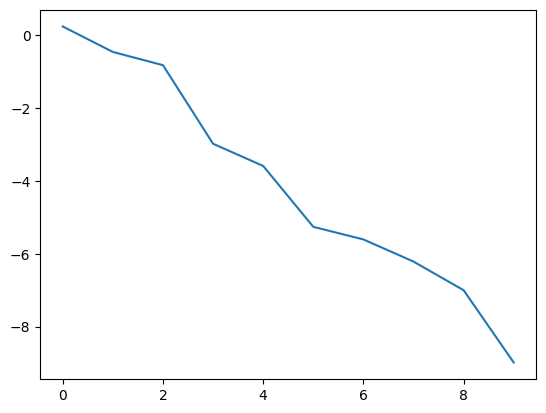

In [50]:
plt.plot(np.log2(lst_lam),np.log2(y))

In [65]:
def error_t(lam,ts,num_points):
    output = []
    rate_x = np.array(np.ones(n))
    rate_z = np.array(np.ones(n))
    V = sum_h_x(n,rate_x).toarray()+sum_h_z(n,rate_z).toarray()
    H_sim = H_enc+lam *H_pen
    LHS = [expm(-1j*(H_sim+V)*t)@P for t in np.linspace(0, ts, num_points)]
    RHS = [expm(-1j*(U@H_tar@dagger(U))*t)@P for t in np.linspace(0, ts, num_points)]
    for i in range(len(LHS)):
        output.append(np.linalg.norm(LHS[i]-RHS[i],ord=2))
    return output

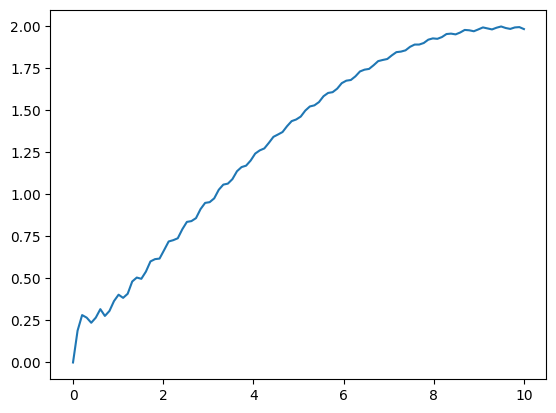

In [68]:
lam = 8
ts = 10

num_points = 100
x = np.linspace(0, ts, num_points)
y = error_t(lam,ts,num_points)

plt.plot(x,y)
